In [1]:
#Import required packages
import torch
from transformers import AutoModel, AutoTokenizer
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from datasets import load_dataset
import numpy as np
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

c:\learn\learnenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Load sample dataset
emotions = load_dataset('emotion')

In [3]:
#Load Distilled BERT model checkpoint
model_checkpoint = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_checkpoint).to(device)

In [4]:
#Load Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [5]:
#Tokenize method
def tokenize(input):
    return tokenizer(input['text'],padding=True,truncation=True)

In [6]:
def extract_last_hidden_state(input_text):
    converted_inputs = {k:v.to(device) for k,v in input_text.items()
                        if k in tokenizer.model_input_names}
    with torch.no_grad():
        output = model(**converted_inputs).last_hidden_state
    return {"hidden_state":output[:,0].cpu().numpy()}

In [7]:
emotions_encoded = emotions.map(tokenize,batched=True,batch_size=None)

In [8]:
emotions_encoded.set_format("torch",columns=["input_ids","attention_mask","label"])

In [9]:
#batch_size is important if GPU with limited capacity
emotions_from_last_hidden_layer = emotions_encoded.map(extract_last_hidden_state,batched=True,batch_size=10)

Map: 100%|██████████| 2000/2000 [00:04<00:00, 477.18 examples/s]


In [10]:
emotions_from_last_hidden_layer

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
})

In [11]:
X_Train = np.array(emotions_from_last_hidden_layer['train']['hidden_state'])
X_Validate = np.array(emotions_from_last_hidden_layer['validation']['hidden_state'])
y_train = np.array(emotions_from_last_hidden_layer['train']['label'])
y_validate = np.array(emotions_from_last_hidden_layer['validation']['label'])
X_Train.shape, X_Validate.shape

((16000, 768), (2000, 768))

In [12]:
X_scaled = MinMaxScaler().fit_transform(X_Train)
mapper = UMAP(n_components=2,metric='cosine').fit(X_scaled)
df_emb = pd.DataFrame(mapper.embedding_,columns=['X','Y'])
df_emb['label'] = y_train
df_emb.head()

,X,Y,label
0,4.140112,2.925519,0
1,-3.158262,3.167696,0
2,4.740597,6.488849,3
3,-2.607116,5.189332,2
4,-3.599755,5.142344,3


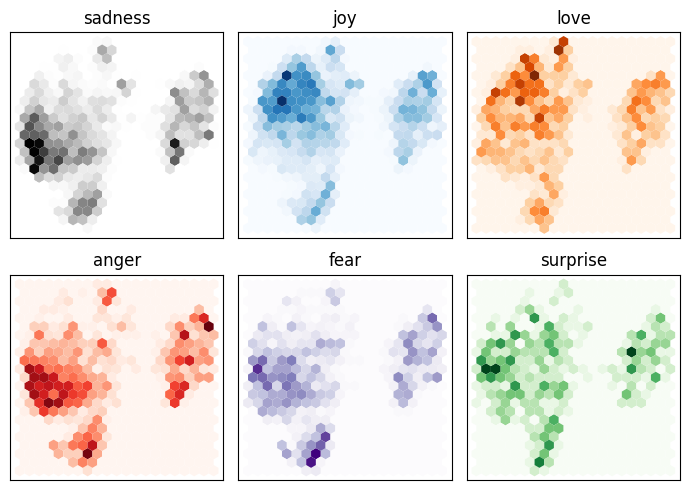

In [13]:
fig,axes = plt.subplots(2,3,figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()


In [14]:
from sklearn.linear_model import LogisticRegression

# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_Train, y_train)
lr_clf.score(X_Validate, y_validate)

0.6335